In [1]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform as skimt
import time
import scipy.sparse as sp
import copy
import matplotlib as mpl
from matplotlib import cm

import pyxu.operator as pyxop
import os
import src.tomo_fusion.tools.helpers as tomo_helps
import src.tomo_fusion.tools.plotting_fcts as tomo_plots
import src.tomo_fusion.bayesian_computations as bcomp
import src.tomo_fusion.functionals_definition as fct_def
import src.tomo_fusion.hyperparameter_tuning as hyper_tune

from pyxu_diffops.operator import AnisDiffusionOp

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu/info/plug

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load phantom data
psis = np.load('sxr_samples/psis.npy')
psis_at_source = np.load('sxr_samples/psis_at_source.npy')
sxr_samples = np.load('sxr_samples/sxr_samples_with_background.npy')
alphas = np.load('sxr_samples/alpha_random_values.npy')
trim_val = np.load('sxr_samples/trimming_values.npy')
random_peak_vals = np.load('sxr_samples/peak_values_gaussian_background.npy')
source_locs = np.load('sxr_samples/source_loc.npy')
diffusive_steps = np.load('sxr_samples/diffusive_steps.npy')
peak_values_gaussian_background = np.load('sxr_samples/peak_values_gaussian_background.npy')

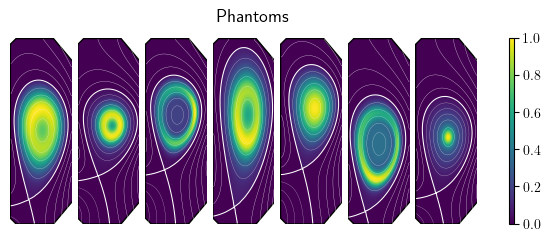

In [11]:
fig,ax=plt.subplots(1,8, figsize=(6.5,2.5), width_ratios=[1,1,1,1,1,1,1,0.5])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})
plt.subplots_adjust(wspace=0.1)

idxs_to_be_plotted = np.array([0,291,126,70,31,90,200])
idxs_to_be_plotted = np.array([0,291,126,70,31,90,46])

for i, idx in enumerate(idxs_to_be_plotted):
    tomo_plots.plot_profile(sxr_samples[idx, :, :], tcv_plot_clip=True, contour_image=psis[idx, :, :],
                         ax=ax[i], colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)
ax[7].axis("off")
from matplotlib import cm
plt.colorbar(cm.ScalarMappable(cmap="viridis"),ax=ax[7], aspect=40)

plt.suptitle(r"Phantoms", fontsize=13)
#plt.savefig('../figures/phantom_dataset.eps', format='eps', bbox_inches="tight")

plt.show()

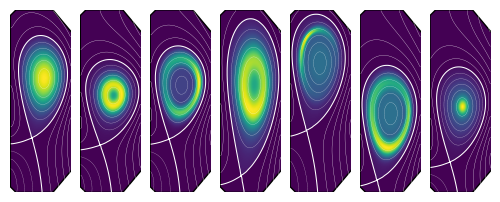

In [22]:
fig,ax=plt.subplots(1,7, figsize=(6.2,2.5), width_ratios=[1,1,1,1,1,1,1])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})
plt.subplots_adjust(wspace=0.15)

#idxs_to_be_plotted = np.array([0,291,126,70,31,90,200])
idxs_to_be_plotted = np.array([31,291,126,70,200,90,46])

for i, idx in enumerate(idxs_to_be_plotted):
    tomo_plots.plot_profile(sxr_samples[idx, :, :], tcv_plot_clip=True, contour_image=psis[idx, :, :],
                         ax=ax[i], colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)
    
#plt.suptitle(r"Phantoms", fontsize=13, y=0.96)
plt.savefig('../figures/phantom_dataset_nocbar.eps', format='eps', bbox_inches="tight")

plt.show()

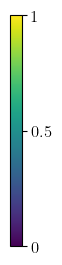

In [14]:
#r=plt.imshow(gaussian_profile)
plt.figure(figsize=(2,3))
r=plt.imshow(sxr_samples[idx,:,:])
plt.gca().set_visible(False)
cbar=plt.colorbar(r, aspect=20)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_yticks([0,0.5,1])
cbar.ax.set_yticklabels([r"$0$",  r"$0.5$", r"$1$"])
plt.axis("off")
plt.savefig('../figures/phantom_generation_cbar.eps', format='eps', bbox_inches="tight")
plt.show()

# Dataset visualization
Run the cell below to visualize the phantoms, by blocks of 20. Change the value of the variable $block$ to visualize a different block.

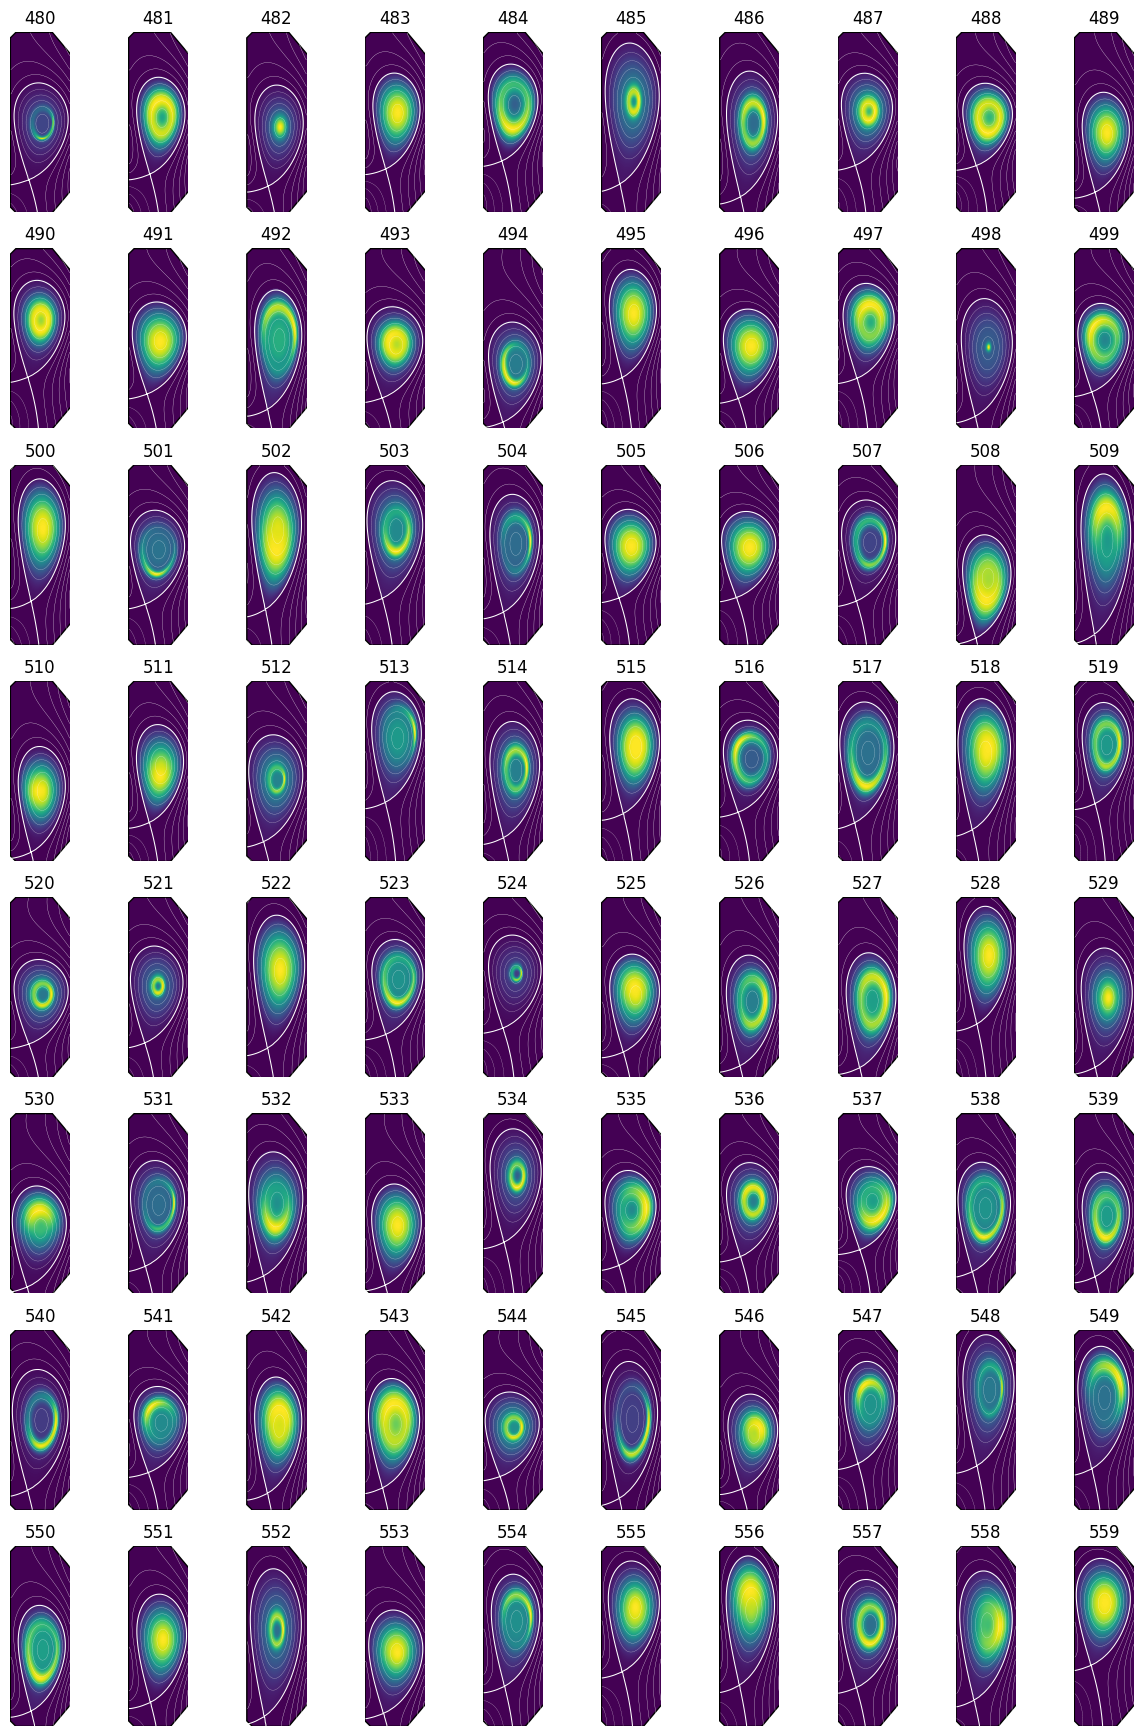

In [9]:
block = 12
fig,ax=plt.subplots(8,10, figsize=(15,22))
for i in range(8):
    for j in range(10):
        ground_truth = sxr_samples[40*block + i*10+j, :, :].squeeze()
        
        
        tomo_plots.plot_profile(sxr_samples[40*block + i*10+j, :, :], tcv_plot_clip=True, contour_image=psis[40*block + i*10+j, :, :],
                         ax=ax[i,j], colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)
        #ax[i, j].contour(psis[20*block + i*5+j, :, :], origin="lower", levels=15, antialiased=True, colors="w", linewidths=0.2)
        ax[i,j].axis('off')
        ax[i,j].set_title("{}".format(40*block + i*10+j))
plt.show()

# Phantom generation
Below, we illustrate the phantom generation process. Phantoms are obtained as the sum between a perturbation and a background:
+ the perturbation is obtained allowing a randomly placed source to diffuse for a random number of iterations;
+ the background is a Gaussian centered at the magnetic axis and decaying as a function of the normalized radius; the peak value of the background is from 1 to 5 times weaker than the perturbation peak.

All phantoms are normalized to 1. 

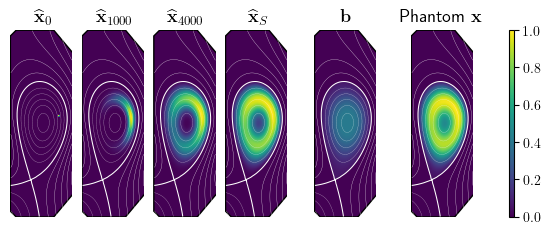

In [305]:
dim_shape=(1,240,80)
idx = 30
source_loc = source_locs[idx]
psi=psis[idx,:,:]
steps = diffusive_steps[idx]
source_loc = np.array([109,61])
sampling = 0.0125


x0 = np.zeros((dim_shape[1], dim_shape[2]))
x0[source_loc[0]:source_loc[0] + 2, source_loc[1]:source_loc[1] + 2] = 1

reg_fct = AnisDiffusionOp(dim_shape=dim_shape,
                          alpha=alphas[idx],
                          diff_method_struct_tens="fd",
                          freezing_arr=psi,
                          sampling=sampling,
                          matrix_based_impl=True)
mask_core = tomo_helps.define_core_mask(psi, dim_shape[1:], trim_values_x=trim_val[idx, :])
checkpoints=[0, int(1e3), int(4e3), diffusive_steps[idx]]
checkpoints = np.sort(checkpoints)
intermediate_steps = []

for s in range(int(1e4+1)):
    if s in checkpoints:
        intermediate_steps.append(copy.deepcopy(x0))
    x0 -= 0.95 * (0.25 * (sampling ** 2)) * reg_fct.grad(x0)
    x0[x0 < 0] = 0
    x0 *= mask_core
    
gaussian_profile = peak_values_gaussian_background[idx] * np.exp(-((psi-np.min(psi))/(np.min(psi)))**2 / (2*0.5**2))
gaussian_profile *= mask_core

fig, ax = plt.subplots(1,9, figsize=(6.5,2.5), width_ratios=[1,1,1,1,0.125,1,0.25,1,0.5])

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

titles = [r"$\widehat{\mathbf{x}}_0$", r"$\widehat{\mathbf{x}}_{1000}$", r"$\widehat{\mathbf{x}}_{4000}$", r"$\widehat{\mathbf{x}}_{S}$", r"$\widehat{\mathbf{x}}_S$", r"$N=0$", r"$N=0$", r"$N=0$"]

for i in range(len(checkpoints)):
    to_be_plotted = intermediate_steps[i] / intermediate_steps[i].max()
    tomo_plots.plot_profile(to_be_plotted, tcv_plot_clip=True, contour_image=psi,
                         ax=ax[i], colorbar=False, contour_color="w", vmax=np.max(to_be_plotted), aspect=None, levels=12)
    ax[i].set_title(titles[i], fontsize=13)

ax[4].axis("off")

tomo_plots.plot_profile(gaussian_profile, tcv_plot_clip=True, contour_image=psi,
                         ax=ax[5], colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)
ax[5].set_title(r"$\mathbf{b}$", fontsize=13)
ax[6].axis("off")
tomo_plots.plot_profile(sxr_samples[idx,:,:], tcv_plot_clip=True, contour_image=psi,
                         ax=ax[7], colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)#"auto")   
ax[7].set_title(r"Phantom $\mathbf{x}$", fontsize=13)
ax[8].axis("off")
plt.colorbar(cm.ScalarMappable(cmap="viridis"),ax=ax[8], aspect=40)

#plt.savefig('../figures/phantom_generation.eps', format='eps', bbox_inches="tight")

plt.show()


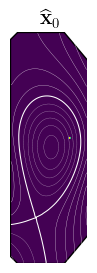

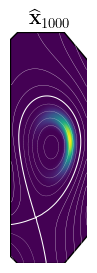

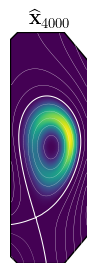

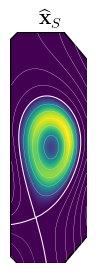

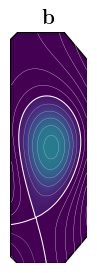

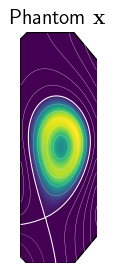

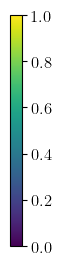

In [327]:
for i in range(len(checkpoints)):
    to_be_plotted = intermediate_steps[i] / intermediate_steps[i].max()
    tomo_plots.plot_profile(to_be_plotted, tcv_plot_clip=True, contour_image=psi,
                         ax=None, colorbar=False, contour_color="w", vmax=np.max(to_be_plotted), aspect=None, levels=12)
    plt.title(titles[i], fontsize=15)
    plt.savefig('../figures/phantom_generation_'+str(i)+'.eps', format='eps', bbox_inches="tight")
    plt.show()
    
tomo_plots.plot_profile(gaussian_profile, tcv_plot_clip=True, contour_image=psi,
                         ax=None, colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)
plt.title(r"$\mathbf{b}$", fontsize=15)
plt.savefig('../figures/phantom_generation_b.eps', format='eps', bbox_inches="tight")
plt.show()

tomo_plots.plot_profile(sxr_samples[idx,:,:], tcv_plot_clip=True, contour_image=psi,
                         ax=None, colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)
plt.title(r"$\mathrm{Phantom}\;\mathbf{x}$", fontsize=15)
plt.savefig('../figures/phantom_generation_x.eps', format='eps', bbox_inches="tight")
plt.show()

#r=plt.imshow(gaussian_profile)
plt.figure(figsize=(2,3))
r=plt.imshow(sxr_samples[idx,:,:])
plt.gca().set_visible(False)
cbar=plt.colorbar(r, aspect=20)
cbar.ax.tick_params(labelsize=12)
plt.axis("off")
plt.savefig('../figures/phantom_generation_cbar.eps', format='eps', bbox_inches="tight")
plt.show()